<a href="https://colab.research.google.com/github/bathicodes/EXPERIMENTS/blob/main/Dogs_vs_Cats_PyTorch_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data

## Import libraries

In [1]:
import torch
from torch import nn
from google.colab import drive

# print torch version
print(torch.__version__)

2.0.0+cu118


In [2]:
# check gpu 
!nvidia-smi

Sun Apr 23 16:57:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Going thorugh data (data preparation and data exploration)

In [4]:
from pathlib import Path

drive.mount("/content/drive")

cloud_path = "/content/drive/MyDrive/Machine Learning/ML Reboot/CNN with dataset/dataset"
path = Path(cloud_path)

# setup train and test path 
train_dir = path / "training_set"
test_dir = path / "test_set"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os

def walk_through(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dir_path}")

In [6]:
walk_through(path)

There are 3 directories and 0 images in /content/drive/MyDrive/Machine Learning/ML Reboot/CNN with dataset/dataset
There are 2 directories and 0 images in /content/drive/MyDrive/Machine Learning/ML Reboot/CNN with dataset/dataset
There are 0 directories and 1000 images in /content/drive/MyDrive/Machine Learning/ML Reboot/CNN with dataset/dataset
There are 0 directories and 1000 images in /content/drive/MyDrive/Machine Learning/ML Reboot/CNN with dataset/dataset
There are 2 directories and 0 images in /content/drive/MyDrive/Machine Learning/ML Reboot/CNN with dataset/dataset
There are 0 directories and 4000 images in /content/drive/MyDrive/Machine Learning/ML Reboot/CNN with dataset/dataset
There are 0 directories and 4001 images in /content/drive/MyDrive/Machine Learning/ML Reboot/CNN with dataset/dataset
There are 0 directories and 4 images in /content/drive/MyDrive/Machine Learning/ML Reboot/CNN with dataset/dataset


## Visualize images 

(-0.5, 499.5, 460.5, -0.5)

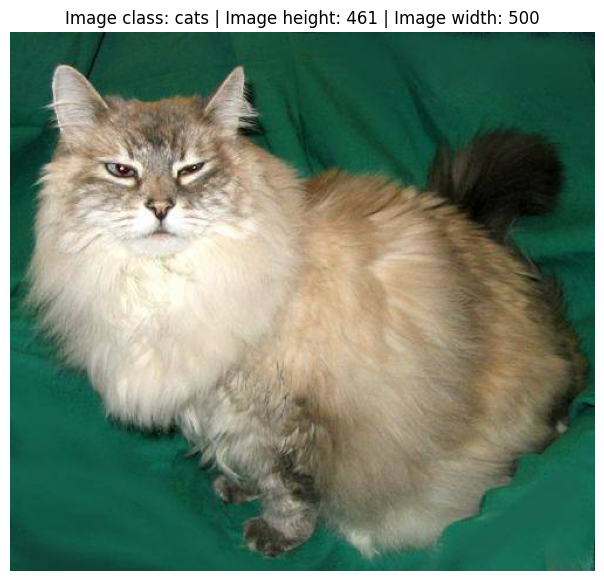

In [7]:
# visualizing with matplotlib

import random
from PIL import Image
import glob
import numpy as np
import matplotlib.pyplot as plt

# set random seed
random.seed(42)

# 1. get all the image paths
image_path_list = list(path.glob("*/*/*.jpg"))

# 2. pick a random image path
random_image_path = random.choice(image_path_list)

# 3. get image class name from path list
image_class = random_image_path.parent.stem

# 4. open image
image = Image.open(random_image_path)

# 5. convert image into array
image_as_array = np.asarray(image)

plt.figure(figsize=(10,7))
plt.imshow(image_as_array)
plt.title(f"Image class: {image_class} | Image height: {image.height} | Image width: {image.width}")
plt.axis(False)

## Transforming the data

In [8]:
from torchvision import datasets, transforms

train_data_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_data_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

## Loading image data using `ImageFolder`

In [9]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_data_transforms,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_data_transforms)

In [10]:
class_names = train_data.classes
class_names

['cats', 'dogs']

In [11]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'cats': 0, 'dogs': 1}

## Turn dataset into `DataLoader`

In [12]:
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

# Model

## Create model

In [13]:
class Model_1(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*54*54, out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x)
    x = self.conv_block_2(x)
    # print(x)
    x = self.classifier(x)
    # print(x)
    return x

In [14]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = Model_1(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_1

Model_1(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=29160, out_features=2, bias=True)
  )
)

## Try a forward pass on a single image (to test the model)

In [15]:
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [16]:
image_batch, label_batch = next(iter(test_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [17]:
model_1(image_batch.to(device))

tensor([[-0.0290,  0.0203],
        [-0.0306,  0.0160],
        [-0.0293,  0.0218],
        [-0.0190,  0.0157],
        [-0.0297,  0.0478],
        [-0.0107,  0.0424],
        [-0.0460,  0.0329],
        [-0.0421,  0.0253],
        [-0.0187,  0.0246],
        [-0.0249,  0.0219],
        [-0.0271,  0.0504],
        [-0.0336,  0.0328],
        [-0.0249,  0.0232],
        [-0.0077,  0.0392],
        [-0.0439,  0.0419],
        [-0.0260,  0.0305],
        [-0.0237,  0.0253],
        [-0.0291,  0.0217],
        [-0.0360,  0.0194],
        [-0.0379,  0.0093],
        [-0.0302,  0.0227],
        [-0.0332,  0.0229],
        [-0.0342, -0.0020],
        [-0.0248,  0.0348],
        [-0.0363,  0.0303],
        [-0.0291,  0.0259],
        [-0.0262,  0.0238],
        [-0.0173,  0.0534],
        [-0.0246,  0.0204],
        [-0.0200,  0.0368],
        [-0.0231,  0.0445],
        [-0.0337,  0.0254]], device='cuda:0', grad_fn=<AddmmBackward0>)

## Use `torchinfo` to get model summary

In [18]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_1, input_size=[1,3,224,224])

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Model_1                                  [1, 2]                    --
├─Sequential: 1-1                        [1, 10, 111, 111]         --
│    └─Conv2d: 2-1                       [1, 10, 222, 222]         280
│    └─ReLU: 2-2                         [1, 10, 222, 222]         --
│    └─MaxPool2d: 2-3                    [1, 10, 111, 111]         --
├─Sequential: 1-2                        [1, 10, 54, 54]           --
│    └─Conv2d: 2-4                       [1, 10, 109, 109]         910
│    └─ReLU: 2-5                         [1, 10, 109, 109]         --
│    └─MaxPool2d: 2-6                    [1, 10, 54, 54]           --
├─Sequential: 1-3                        [1, 2]                    --
│    └─Flatten: 2-7                      [1, 29160]                --
│    └─Linear: 2-8                       [1, 2]                    58,322
Total params: 59,512
Trainable params: 59,512
Non-trainable params: 0
Total mul

## Create train and test loops

In [19]:

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device = device):
  
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X,y) in enumerate(dataloader):

    X,y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred_class = torch.argmax(torch.sigmoid(y_pred),dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [20]:

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  
  model.eval()

  test_loss, test_acc = 0, 0

  with torch.inference_mode():

    for batch, (X,y) in enumerate(dataloader):

      X,y = X.to(device), y.to(device)

      test_pred_logits = model(X)

      test_loss = loss_fn(test_pred_logits, y)
      test_loss += test_loss.item()

      test_pred_class = test_pred_logits.argmax(dim=1)
      test_acc += (test_pred_class == y).sum().item() / len(test_pred_logits)

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

## Create train function to function to combine train_step() and test_step()

In [21]:
from torch.nn.modules import loss
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = torch.nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device):
  
  results = {
      "train_loss": [],
      "train_accuracy": [],
      "test_loss": [],
      "test_accuracy": []
  }

  for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    
    print(f"Epochs: {epoch} | Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["train_accuracy"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_accuracy"].append(test_acc)

  return results

## Train and evaluate model

In [22]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 5

model_1 = Model_1(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                              lr=0.001)

from timeit import default_timer as timer

start_time = timer()

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=EPOCHS,
                        device=device)

end_time = timer()

print(f"Total training time {end_time - start_time:.3f} seconds.")

  0%|          | 0/5 [00:00<?, ?it/s]

Epochs: 0 | Train loss: 0.6819 | Train accuracy: 0.5692 | Test loss: 0.0187 | Test accuracy: 0.6414
Epochs: 1 | Train loss: 0.6333 | Train accuracy: 0.6392 | Test loss: 0.0188 | Test accuracy: 0.6553
Epochs: 2 | Train loss: 0.6001 | Train accuracy: 0.6716 | Test loss: 0.0227 | Test accuracy: 0.6721
Epochs: 3 | Train loss: 0.5719 | Train accuracy: 0.6897 | Test loss: 0.0188 | Test accuracy: 0.6920
Epochs: 4 | Train loss: 0.5538 | Train accuracy: 0.7130 | Test loss: 0.0251 | Test accuracy: 0.6751
Total training time 441.715 seconds.


In [23]:
model_1_results

{'train_loss': [0.6818675845267763,
  0.63330524209961,
  0.6000563518934516,
  0.5719344522729813,
  0.5537856577402092],
 'train_accuracy': [0.5692231075697212,
  0.6391932270916335,
  0.6715637450199203,
  0.6897410358565738,
  0.7130229083665338],
 'test_loss': [tensor(0.0187, device='cuda:0'),
  tensor(0.0188, device='cuda:0'),
  tensor(0.0227, device='cuda:0'),
  tensor(0.0188, device='cuda:0'),
  tensor(0.0251, device='cuda:0')],
 'test_accuracy': [0.6413690476190477,
  0.6552579365079365,
  0.6721230158730159,
  0.6919642857142857,
  0.6750992063492064]}

## Plot loss curves

In [26]:
from typing import Tuple, Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary"""

  test_loss = []

  # get the loss values from the results dictionary
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # get the accuracy values from the results dictionary
  accuracy = results["train_accuracy"]
  test_accuracy = results["test_accuracy"]

  # figure out the epochs count
  epochs = range(len(results["train_loss"]))

  # setup a plot
  plt.figure(figsize=(15,7))

  # # plot loss curves
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # # plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs") 
  plt.legend()

TypeError: ignored

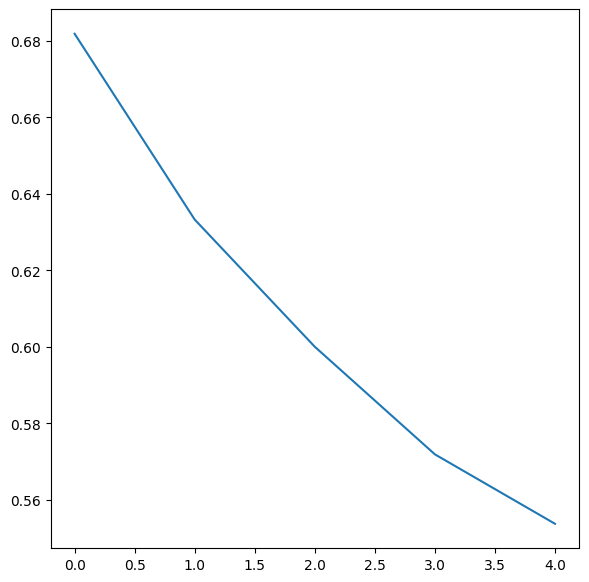

In [27]:
plot_loss_curves(model_1_results)